# Exploratory Data Analysis - California ACS Person Data (DuckDB Version)

This notebook performs EDA using DuckDB for efficient SQL-based analysis on the Census ACS microdata.

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Create in-memory DuckDB connection and load from CSV
con = duckdb.connect(':memory:')

# Load the CSV data into DuckDB
CSV_PATH = "../1_Raw_Data/data_persons_ca_1yr/psam_p06_master.csv"
TABLE = "census_data"
TARGET = "POVPIP"

print("Loading CSV into DuckDB...")
con.execute(f"""
CREATE TABLE {TABLE} AS 
SELECT * FROM read_csv_auto('{CSV_PATH}')
""")

# Verify load
row_count = con.execute(f"SELECT COUNT(*) FROM {TABLE}").fetchone()[0]
print(f"Loaded {row_count:,} rows into DuckDB table '{TABLE}'")

Loading CSV into DuckDB...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded 1,928,458 rows into DuckDB table 'census_data'


In [2]:
# Get schema information
schema = con.execute(f"DESCRIBE {TABLE}").fetchdf()
print(f"Total columns: {len(schema)}")
print(f"\nColumn types:")
print(schema['column_type'].value_counts())

Total columns: 278

Column types:
column_type
BIGINT     193
DOUBLE      81
VARCHAR      4
Name: count, dtype: int64


## Target Variable Analysis (POVPIP)

POVPIP is the income-to-poverty ratio recode:
- Values 0-100: Below poverty threshold (100 = exactly at poverty line)
- Values 101-500: Above poverty threshold (up to 5x poverty line)
- Value 501: 501% or more of poverty threshold (capped)

For our **multiclass classification** task, we define 4 poverty levels based on POVPIP:
- **Deep Poverty** (0-50): Severe economic hardship, less than half the poverty threshold
- **Poverty** (51-100): Below poverty line
- **Near Poverty** (101-200): Above poverty line but vulnerable, low financial buffer
- **Stable** (201+): More than twice the poverty threshold, relatively secure

In [3]:
# POVPIP statistics
povpip_stats = con.execute(f"""
SELECT
    COUNT(*) AS total_records,
    SUM(CASE WHEN {TARGET} IS NULL THEN 1 ELSE 0 END) AS null_count,
    SUM(CASE WHEN {TARGET} IS NOT NULL THEN 1 ELSE 0 END) AS valid_count,
    AVG({TARGET}) AS mean_povpip,
    MEDIAN({TARGET}) AS median_povpip,
    STDDEV({TARGET}) AS std_povpip,
    MIN({TARGET}) AS min_povpip,
    MAX({TARGET}) AS max_povpip,
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY {TARGET}) AS q25,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY {TARGET}) AS q75
FROM {TABLE}
""").fetchdf()

print("=== POVPIP Statistics ===")
print(povpip_stats.T)

=== POVPIP Statistics ===
                          0
total_records  1.928458e+06
null_count     7.083200e+04
valid_count    1.857626e+06
mean_povpip    3.393265e+02
median_povpip  3.810000e+02
std_povpip     1.664055e+02
min_povpip     0.000000e+00
max_povpip     5.010000e+02
q25            1.940000e+02
q75            5.010000e+02


In [4]:
# Multiclass poverty classification
poverty_counts = con.execute(f"""
SELECT
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS percentage
FROM {TABLE}
WHERE {TARGET} IS NOT NULL
GROUP BY 1
ORDER BY 
    CASE 
        WHEN poverty_class = 'Deep Poverty' THEN 1
        WHEN poverty_class = 'Poverty' THEN 2
        WHEN poverty_class = 'Near Poverty' THEN 3
        ELSE 4
    END
""").fetchdf()

print("=== Multiclass Poverty Classification ===")
print(poverty_counts)

# Calculate combined poverty rate (Deep Poverty + Poverty)
below_poverty = poverty_counts[poverty_counts['poverty_class'].isin(['Deep Poverty', 'Poverty'])]['count'].sum()
total = poverty_counts['count'].sum()
print(f"\nBelow Poverty Line (Deep Poverty + Poverty): {below_poverty:,} ({below_poverty/total*100:.2f}%)")

=== Multiclass Poverty Classification ===
  poverty_class    count  percentage
0  Deep Poverty   104528        5.63
1       Poverty   109241        5.88
2  Near Poverty   268696       14.46
3        Stable  1375161       74.03

Below Poverty Line (Deep Poverty + Poverty): 213,769 (11.51%)


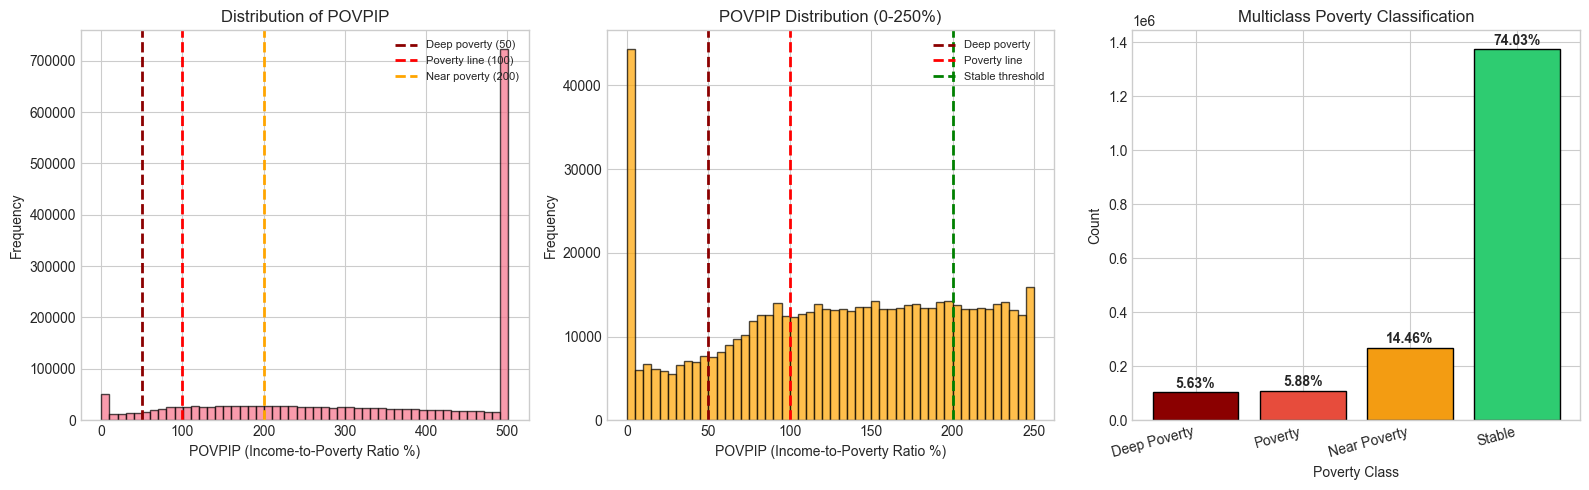

In [5]:
# POVPIP Distribution Visualization
df_povpip = con.execute(f"""
SELECT {TARGET} FROM {TABLE}
WHERE {TARGET} IS NOT NULL
""").fetchdf()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Full distribution with class boundaries
axes[0].hist(df_povpip[TARGET], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=50, color='darkred', linestyle='--', linewidth=2, label='Deep poverty (50)')
axes[0].axvline(x=100, color='red', linestyle='--', linewidth=2, label='Poverty line (100)')
axes[0].axvline(x=200, color='orange', linestyle='--', linewidth=2, label='Near poverty (200)')
axes[0].set_xlabel('POVPIP (Income-to-Poverty Ratio %)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of POVPIP')
axes[0].legend(fontsize=8)

# Zoomed view (0-250) with class boundaries
axes[1].hist(df_povpip[df_povpip[TARGET] <= 250][TARGET], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=50, color='darkred', linestyle='--', linewidth=2, label='Deep poverty')
axes[1].axvline(x=100, color='red', linestyle='--', linewidth=2, label='Poverty line')
axes[1].axvline(x=200, color='green', linestyle='--', linewidth=2, label='Stable threshold')
axes[1].set_xlabel('POVPIP (Income-to-Poverty Ratio %)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('POVPIP Distribution (0-250%)')
axes[1].legend(fontsize=8)

# Multiclass classification bar chart
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_colors = ['#8B0000', '#e74c3c', '#f39c12', '#2ecc71']

# Reorder poverty_counts to match class_order
poverty_counts_ordered = poverty_counts.set_index('poverty_class').reindex(class_order).reset_index()

bars = axes[2].bar(poverty_counts_ordered['poverty_class'], poverty_counts_ordered['count'], 
                   color=class_colors, edgecolor='black')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Poverty Class')
axes[2].set_title('Multiclass Poverty Classification')
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=15, ha='right')

for bar, pct in zip(bars, poverty_counts_ordered['percentage']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
                 f'{pct}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_data/duckdb_povpip_distribution_multiclass.png', dpi=150, bbox_inches='tight')
plt.show()

## Section 2: Correlation Analysis with POVPIP

Computing Pearson correlations between numeric features and POVPIP using DuckDB's built-in `corr()` function.

In [6]:
# Get numeric columns
numeric_types = {'BIGINT', 'INTEGER', 'SMALLINT', 'TINYINT', 'DOUBLE', 'FLOAT', 'REAL', 'DECIMAL'}
num_cols = schema[schema['column_type'].str.upper().str.split('(').str[0].isin(numeric_types)]['column_name'].tolist()
num_cols = [c for c in num_cols if c.upper() != TARGET.upper()]

print(f"Found {len(num_cols)} numeric columns for correlation analysis")

# Compute correlations using DuckDB
correlations = []
for col in num_cols:
    result = con.execute(f"""
    SELECT
        '{col}' AS column,
        corr("{col}", "{TARGET}") AS correlation
    FROM {TABLE}
    WHERE "{col}" IS NOT NULL AND "{TARGET}" IS NOT NULL
    """).fetchone()
    if result[1] is not None:
        correlations.append({'column': result[0], 'correlation': result[1]})

corr_df = pd.DataFrame(correlations)
corr_df['abs_corr'] = corr_df['correlation'].abs()
corr_df = corr_df.sort_values('abs_corr', ascending=False).reset_index(drop=True)

Found 273 numeric columns for correlation analysis


In [7]:
# Load data dictionary for labels
dict_path = "EDA_data/suggested_clean_data_dictionary.csv"
try:
    df_dict = pd.read_csv(dict_path)
    corr_df = corr_df.merge(df_dict[['column', 'label']], on='column', how='left')
    corr_df['short_label'] = corr_df['label'].apply(lambda x: str(x)[:45] + '...' if pd.notna(x) and len(str(x)) > 45 else str(x))
except:
    corr_df['short_label'] = corr_df['column']

print("=== Top 35 Features Correlated with POVPIP ===")
print("-" * 90)
for i, row in corr_df.head(35).iterrows():
    label = row.get('short_label', row['column'])
    print(f"{row['column']:12} | r={row['correlation']:+.3f} | {label}")

=== Top 35 Features Correlated with POVPIP ===
------------------------------------------------------------------------------------------
PRIVCOV      | r=-0.470 | Private health insurance coverage recode
HINS4        | r=+0.454 | Medicaid, Medical Assistance, or any kind of ...
HINS1        | r=-0.439 | Insurance through a current or former employe...
ESP          | r=-0.425 | nan
NOP          | r=-0.417 | nan
PINCP        | r=+0.416 | Total person's income (use ADJINC to adjust t...
PERNP        | r=+0.372 | Total person's earnings (use ADJINC to adjust...
WAGP         | r=+0.363 | Wages or salary income past 12 months (use AD...
PUBCOV       | r=+0.350 | Public health coverage recode
OCCP         | r=-0.284 | Occupation recode for 2018 and later based on...
WRK          | r=-0.265 | Worked last week
SCHL         | r=+0.264 | Educational attainment
ESR          | r=-0.250 | Employment status recode
WKL          | r=-0.245 | When last worked
MSP          | r=-0.244 | Married, spouse p

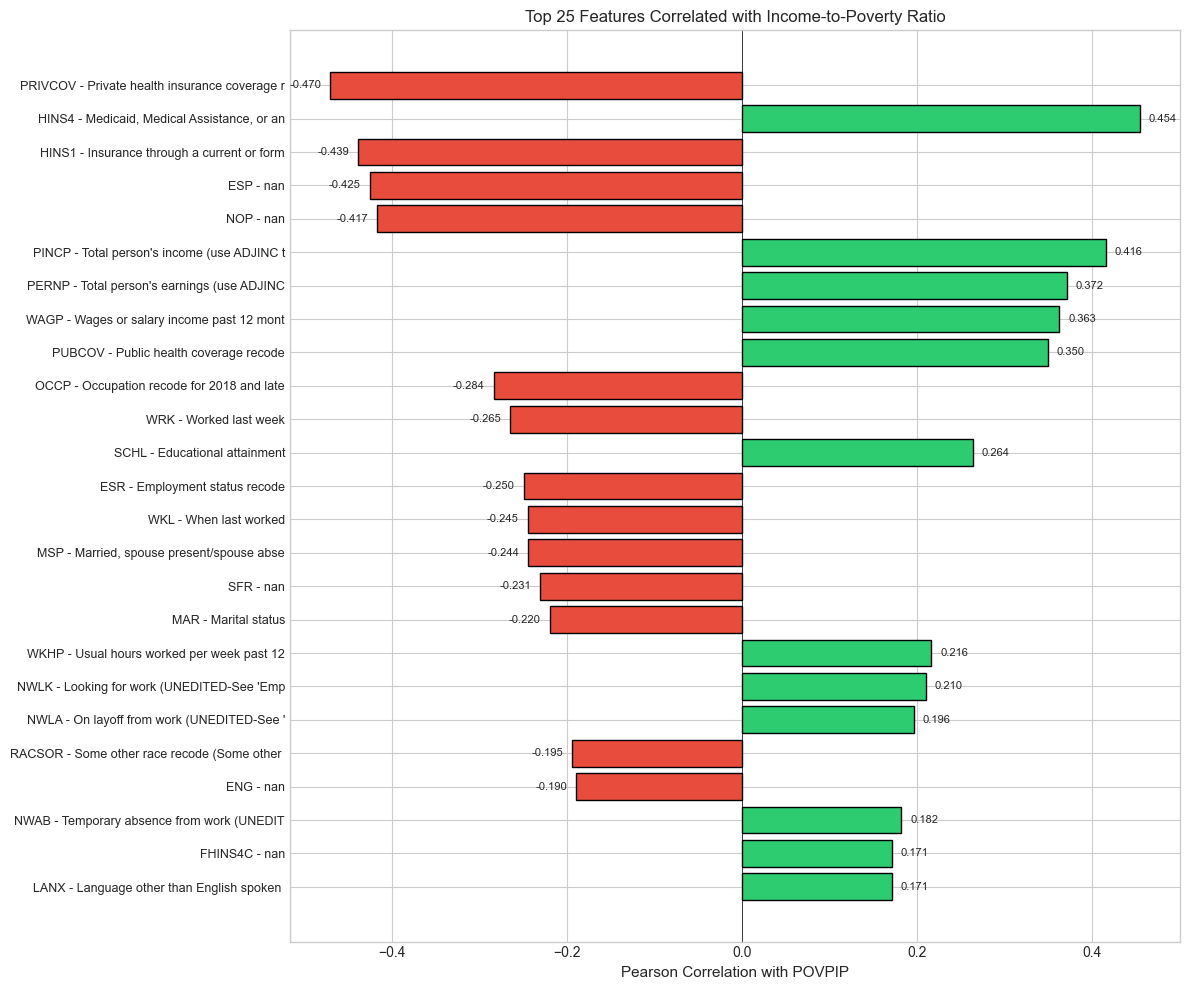


Interpretation:
- GREEN (positive): Higher values = HIGHER income-to-poverty ratio (less likely poor)
- RED (negative): Higher values = LOWER income-to-poverty ratio (more likely poor)


In [8]:
# Visualize top correlations with labels
top_n = 25
top_corr = corr_df.head(top_n).copy()

fig, ax = plt.subplots(figsize=(12, 10))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_corr['correlation']]

y_labels = [f"{row['column']} - {str(row.get('short_label', ''))[:35]}" for _, row in top_corr.iterrows()]

ax.barh(range(len(top_corr)), top_corr['correlation'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(y_labels, fontsize=9)
ax.set_xlabel('Pearson Correlation with POVPIP', fontsize=11)
ax.set_title(f'Top {top_n} Features Correlated with Income-to-Poverty Ratio', fontsize=12)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.invert_yaxis()

for i, row in top_corr.iterrows():
    ax.text(row['correlation'] + 0.01 if row['correlation'] > 0 else row['correlation'] - 0.01,
            i, f"{row['correlation']:.3f}", va='center',
            ha='left' if row['correlation'] > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.savefig('EDA_data/duckdb_correlation_with_povpip.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- GREEN (positive): Higher values = HIGHER income-to-poverty ratio (less likely poor)")
print("- RED (negative): Higher values = LOWER income-to-poverty ratio (more likely poor)")

## Variance Analysis

Identifying features with low variance (most values are the same) - candidates for removal.

In [9]:
# Variance analysis using DuckDB
variance_stats = []
for col in num_cols:
    result = con.execute(f"""
    SELECT
        '{col}' AS column,
        COUNT("{col}") AS non_null_count,
        COUNT(DISTINCT "{col}") AS unique_values,
        VARIANCE("{col}") AS variance,
        MODE("{col}") AS mode_value
    FROM {TABLE}
    WHERE "{col}" IS NOT NULL
    """).fetchone()
    
    # Calculate mode percentage
    mode_pct_result = con.execute(f"""
    SELECT 
        ROUND(MAX(cnt) * 100.0 / SUM(cnt), 2) AS mode_pct
    FROM (
        SELECT "{col}", COUNT(*) AS cnt
        FROM {TABLE}
        WHERE "{col}" IS NOT NULL
        GROUP BY "{col}"
    )
    """).fetchone()[0]
    
    variance_stats.append({
        'column': result[0],
        'non_null_count': result[1],
        'unique_values': result[2],
        'variance': result[3],
        'mode_pct': mode_pct_result
    })

variance_df = pd.DataFrame(variance_stats)
variance_df = variance_df.sort_values('mode_pct', ascending=False)

# Low variance features (mode > 95%)
low_var_features = variance_df[variance_df['mode_pct'] > 95]
print(f"=== Low Variance Features (mode > 95% of values): {len(low_var_features)} ===")
print(low_var_features[['column', 'mode_pct', 'unique_values']].to_string())

=== Low Variance Features (mode > 95% of values): 40 ===
       column  mode_pct  unique_values
0    DIVISION    100.00              1
3      REGION    100.00              1
120     FANCP    100.00              1
130    FDRATP     99.99              2
184     FSEXP     99.95              2
138     FGCMP     99.89              2
107     RACNH     99.77              2
190     FWRKP     99.74              2
137     FGCLP     99.69              2
29      HINS7     99.58              2
97      POWSP     99.57             58
131   FDRATXP     99.52              2
139     FGCRP     99.50              2
109     RACPI     99.44              2
167    FMILPP     99.42              2
35      MARHD     99.12              2
38      MARHW     99.11              2
151     FHISP     98.62              2
119     FAGEP     98.45              2
28      HINS6     98.25              2
55        PAP     98.16            313
48       MLPJ     98.03              2
147   FHINS5C     97.92              2
178    

## Poverty Analysis by Key Demographics

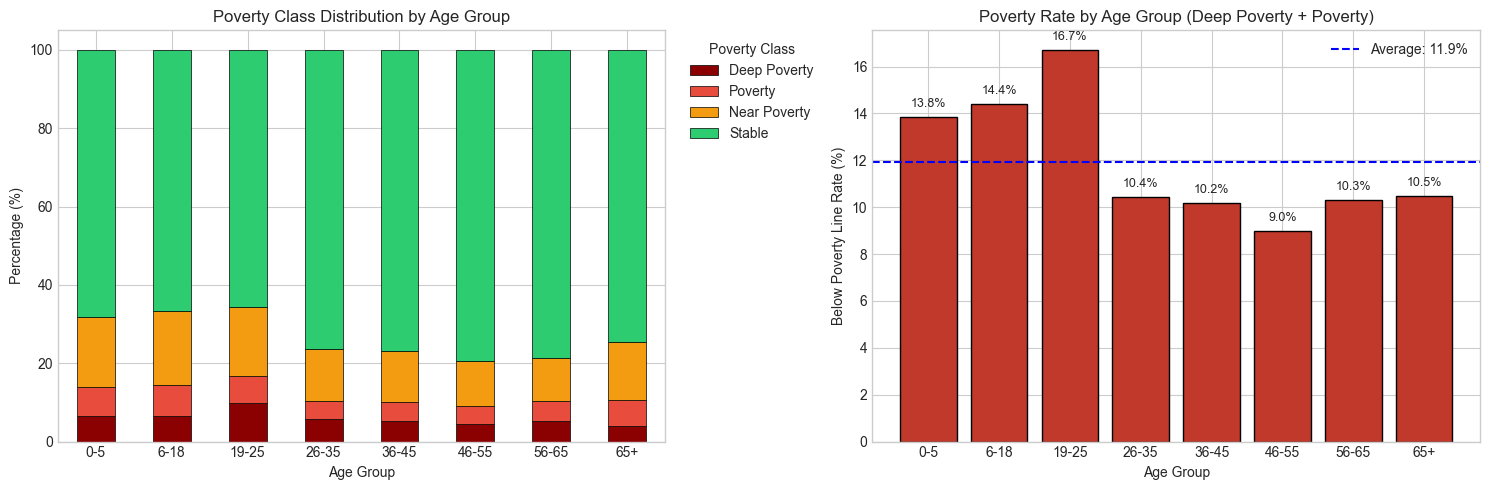


Poverty Class Distribution by Age Group (%):
poverty_class  Deep Poverty  Poverty  Near Poverty  Stable
age_group                                                 
0-5                     6.4      7.4          18.0    68.2
6-18                    6.5      7.9          18.8    66.7
19-25                   9.8      7.0          17.6    65.7
26-35                   5.7      4.7          13.2    76.4
36-45                   5.2      5.0          13.0    76.8
46-55                   4.6      4.4          11.6    79.4
56-65                   5.2      5.1          11.1    78.6
65+                     4.1      6.4          14.9    74.6


In [10]:
# Poverty Class Distribution by Age Groups
age_poverty = con.execute(f"""
SELECT
    CASE 
        WHEN AGEP <= 5 THEN '0-5'
        WHEN AGEP <= 18 THEN '6-18'
        WHEN AGEP <= 25 THEN '19-25'
        WHEN AGEP <= 35 THEN '26-35'
        WHEN AGEP <= 45 THEN '36-45'
        WHEN AGEP <= 55 THEN '46-55'
        WHEN AGEP <= 65 THEN '56-65'
        ELSE '65+'
    END AS age_group,
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count
FROM {TABLE}
WHERE AGEP IS NOT NULL AND {TARGET} IS NOT NULL
GROUP BY 1, 2
ORDER BY MIN(AGEP), 
    CASE 
        WHEN poverty_class = 'Deep Poverty' THEN 1
        WHEN poverty_class = 'Poverty' THEN 2
        WHEN poverty_class = 'Near Poverty' THEN 3
        ELSE 4
    END
""").fetchdf()

# Pivot for stacked bar chart
age_pivot = age_poverty.pivot(index='age_group', columns='poverty_class', values='count').fillna(0)
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
age_pivot = age_pivot[class_order]
age_pivot_pct = age_pivot.div(age_pivot.sum(axis=1), axis=0) * 100

# Reorder index
age_order = ['0-5', '6-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+']
age_pivot_pct = age_pivot_pct.reindex(age_order)

class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Stacked bar chart
age_pivot_pct.plot(kind='bar', stacked=True, ax=axes[0], 
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Age Group')
axes[0].legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Vulnerable rate (Deep Poverty + Poverty)
vulnerable_rate = (age_pivot_pct['Deep Poverty'] + age_pivot_pct['Poverty'])
bars = axes[1].bar(vulnerable_rate.index, vulnerable_rate.values, color='#c0392b', edgecolor='black')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Age Group (Deep Poverty + Poverty)')
axes[1].axhline(y=vulnerable_rate.mean(), color='blue', linestyle='--', label=f'Average: {vulnerable_rate.mean():.1f}%')
axes[1].legend()
for bar, rate in zip(bars, vulnerable_rate.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('EDA_data/duckdb_poverty_class_by_age.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Age Group (%):")
print(age_pivot_pct.round(1).to_string())

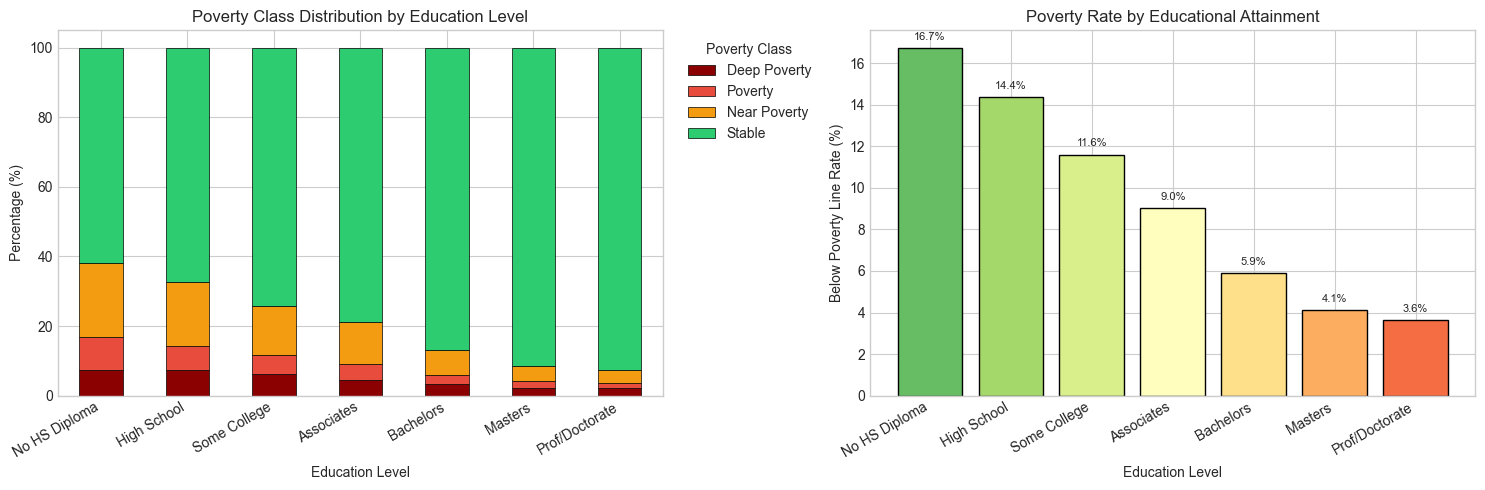


Poverty Class Distribution by Education Level (%):
poverty_class   Deep Poverty  Poverty  Near Poverty  Stable
education                                                  
No HS Diploma            7.5      9.3          21.5    61.8
High School              7.2      7.1          18.4    67.2
Some College             6.1      5.5          14.2    74.2
Associates               4.5      4.5          12.0    78.9
Bachelors                3.3      2.6           7.1    87.0
Masters                  2.3      1.8           4.5    91.4
Prof/Doctorate           2.1      1.5           3.8    92.5


In [11]:
# Poverty Class Distribution by Education Level
edu_poverty = con.execute(f"""
SELECT
    CASE 
        WHEN SCHL BETWEEN 1 AND 15 THEN 'No HS Diploma'
        WHEN SCHL IN (16, 17) THEN 'High School'
        WHEN SCHL IN (18, 19) THEN 'Some College'
        WHEN SCHL = 20 THEN 'Associates'
        WHEN SCHL = 21 THEN 'Bachelors'
        WHEN SCHL = 22 THEN 'Masters'
        WHEN SCHL IN (23, 24) THEN 'Prof/Doctorate'
        ELSE NULL
    END AS education,
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count
FROM {TABLE}
WHERE SCHL IS NOT NULL AND {TARGET} IS NOT NULL
GROUP BY 1, 2
HAVING education IS NOT NULL
""").fetchdf()

# Pivot for stacked bar chart
edu_pivot = edu_poverty.pivot(index='education', columns='poverty_class', values='count').fillna(0)
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
edu_pivot = edu_pivot[class_order]
edu_pivot_pct = edu_pivot.div(edu_pivot.sum(axis=1), axis=0) * 100

# Reorder index
edu_order = ['No HS Diploma', 'High School', 'Some College', 'Associates', 'Bachelors', 'Masters', 'Prof/Doctorate']
edu_pivot_pct = edu_pivot_pct.reindex(edu_order)

class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Stacked bar chart
edu_pivot_pct.plot(kind='bar', stacked=True, ax=axes[0],
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Education Level')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Education Level')
axes[0].legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=30, ha='right')

# Vulnerable rate
vulnerable_rate = edu_pivot_pct['Deep Poverty'] + edu_pivot_pct['Poverty']
colors_gradient = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(vulnerable_rate)))
bars = axes[1].bar(range(len(vulnerable_rate)), vulnerable_rate.values, color=colors_gradient, edgecolor='black')
axes[1].set_xticks(range(len(vulnerable_rate)))
axes[1].set_xticklabels(edu_order, rotation=30, ha='right')
axes[1].set_xlabel('Education Level')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Educational Attainment')
for bar, rate in zip(bars, vulnerable_rate.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('EDA_data/duckdb_poverty_class_by_education.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Education Level (%):")
print(edu_pivot_pct.round(1).to_string())

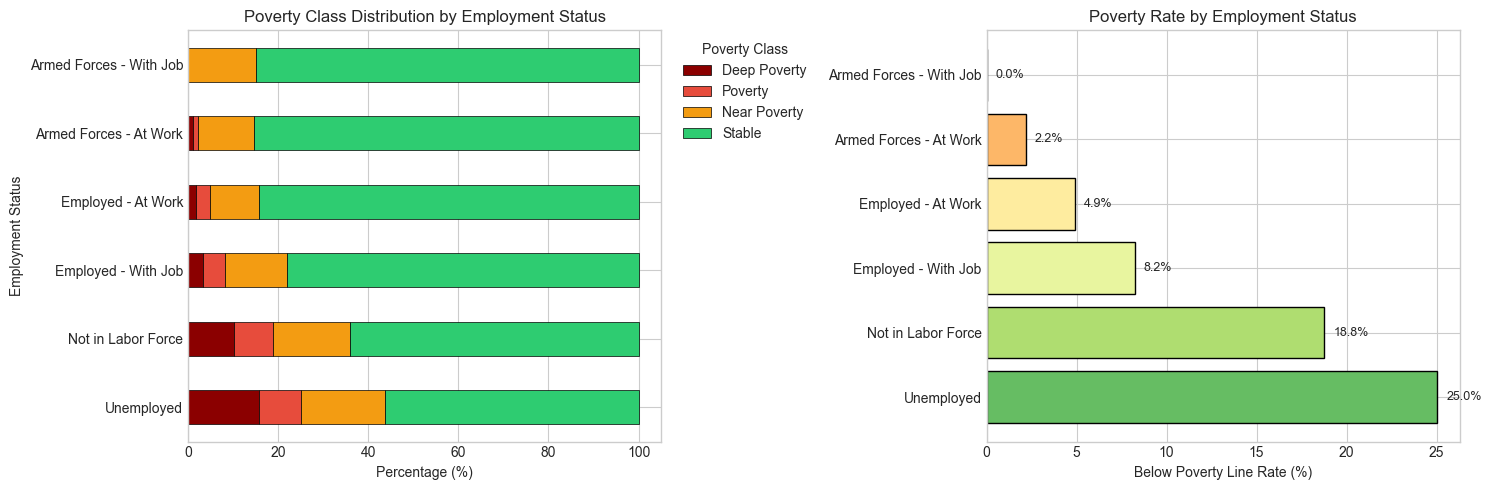


Poverty Class Distribution by Employment Status (%):
poverty_class            Deep Poverty  Poverty  Near Poverty  Stable
employment_status                                                   
Unemployed                       15.8      9.2          18.8    56.2
Not in Labor Force               10.2      8.6          17.2    64.0
Employed - With Job               3.4      4.8          13.7    78.1
Employed - At Work                1.7      3.2          10.8    84.2
Armed Forces - At Work            1.1      1.0          12.5    85.4
Armed Forces - With Job           0.0      0.0          15.0    85.0


In [12]:
# Poverty Class Distribution by Employment Status
emp_poverty = con.execute(f"""
SELECT
    CASE ESR
        WHEN 1 THEN 'Employed - At Work'
        WHEN 2 THEN 'Employed - With Job'
        WHEN 3 THEN 'Unemployed'
        WHEN 4 THEN 'Armed Forces - At Work'
        WHEN 5 THEN 'Armed Forces - With Job'
        WHEN 6 THEN 'Not in Labor Force'
        ELSE 'Unknown'
    END AS employment_status,
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count
FROM {TABLE}
WHERE ESR IS NOT NULL AND {TARGET} IS NOT NULL
GROUP BY 1, 2
""").fetchdf()

# Pivot for stacked bar chart
emp_pivot = emp_poverty.pivot(index='employment_status', columns='poverty_class', values='count').fillna(0)
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
emp_pivot = emp_pivot[class_order]
emp_pivot_pct = emp_pivot.div(emp_pivot.sum(axis=1), axis=0) * 100

# Sort by vulnerable rate
vulnerable_rate = emp_pivot_pct['Deep Poverty'] + emp_pivot_pct['Poverty']
emp_pivot_pct = emp_pivot_pct.loc[vulnerable_rate.sort_values(ascending=False).index]

class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Stacked horizontal bar chart
emp_pivot_pct.plot(kind='barh', stacked=True, ax=axes[0],
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Percentage (%)')
axes[0].set_ylabel('Employment Status')
axes[0].set_title('Poverty Class Distribution by Employment Status')
axes[0].legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')

# Vulnerable rate comparison
vulnerable_sorted = (emp_pivot_pct['Deep Poverty'] + emp_pivot_pct['Poverty'])
colors_gradient = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(vulnerable_sorted)))
bars = axes[1].barh(range(len(vulnerable_sorted)), vulnerable_sorted.values, color=colors_gradient, edgecolor='black')
axes[1].set_yticks(range(len(vulnerable_sorted)))
axes[1].set_yticklabels(vulnerable_sorted.index)
axes[1].set_xlabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Employment Status')
for bar, rate in zip(bars, vulnerable_sorted.values):
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{rate:.1f}%', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('EDA_data/duckdb_poverty_class_by_employment.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Employment Status (%):")
print(emp_pivot_pct.round(1).to_string())

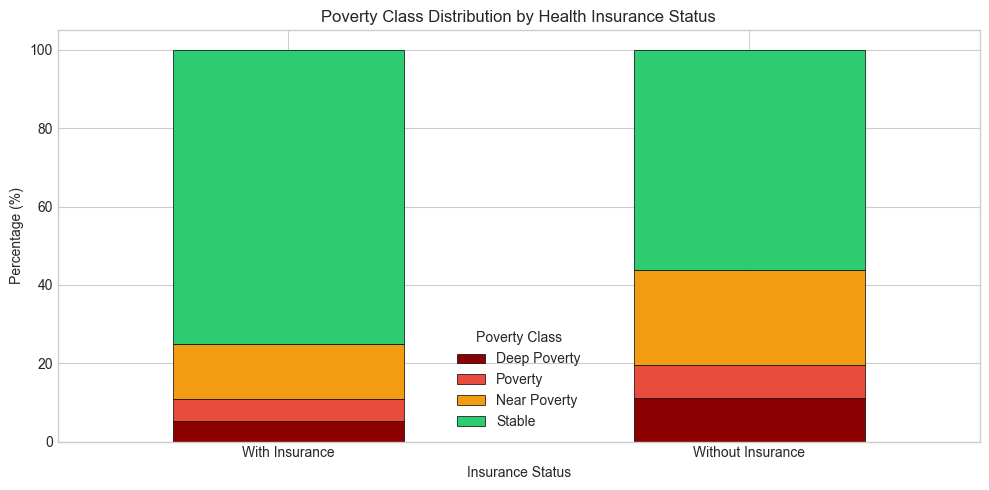

=== Poverty Class by Insurance Status (%) ===
poverty_class      Deep Poverty  Poverty  Near Poverty  Stable
insurance_status                                              
With Insurance              5.3      5.7          13.8    75.2
Without Insurance          11.0      8.6          24.2    56.1


In [13]:
# Poverty Class Distribution by Health Insurance Coverage
insurance_poverty = con.execute(f"""
SELECT
    CASE HICOV
        WHEN 1 THEN 'With Insurance'
        WHEN 2 THEN 'Without Insurance'
    END AS insurance_status,
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count
FROM {TABLE}
WHERE HICOV IS NOT NULL AND {TARGET} IS NOT NULL
GROUP BY 1, 2
""").fetchdf()

# Pivot for visualization
ins_pivot = insurance_poverty.pivot(index='insurance_status', columns='poverty_class', values='count').fillna(0)
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
ins_pivot = ins_pivot[class_order]
ins_pivot_pct = ins_pivot.div(ins_pivot.sum(axis=1), axis=0) * 100

class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

fig, ax = plt.subplots(figsize=(10, 5))
ins_pivot_pct.plot(kind='bar', stacked=True, ax=ax,
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
ax.set_xlabel('Insurance Status')
ax.set_ylabel('Percentage (%)')
ax.set_title('Poverty Class Distribution by Health Insurance Status')
ax.legend(title='Poverty Class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('EDA_data/duckdb_poverty_class_by_insurance.png', dpi=150, bbox_inches='tight')
plt.show()

print("=== Poverty Class by Insurance Status (%) ===")
print(ins_pivot_pct.round(1).to_string())

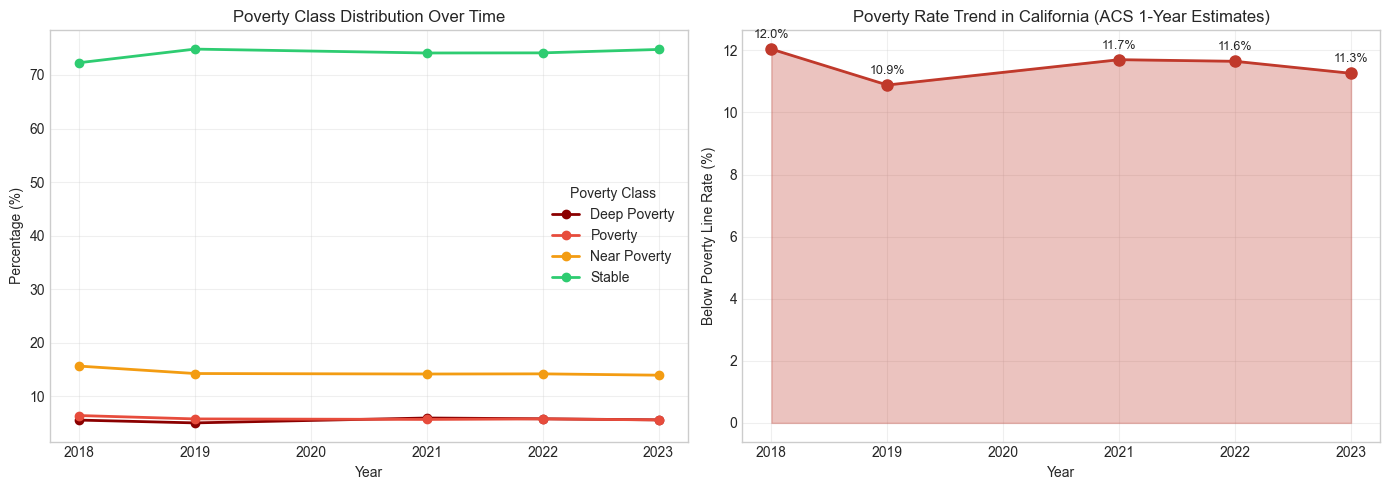


Poverty Class Distribution by Year (%):
poverty_class  Deep Poverty  Poverty  Near Poverty  Stable
year                                                      
2018                    5.6      6.4          15.7    72.3
2019                    5.1      5.8          14.3    74.8
2021                    6.0      5.7          14.2    74.1
2022                    5.8      5.8          14.2    74.1
2023                    5.6      5.6          14.0    74.8


In [14]:
# Poverty Class Trends Over Time
year_poverty = con.execute(f"""
SELECT
    year,
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count
FROM {TABLE}
WHERE year IS NOT NULL AND {TARGET} IS NOT NULL
GROUP BY 1, 2
ORDER BY 1
""").fetchdf()

# Pivot for time series
year_pivot = year_poverty.pivot(index='year', columns='poverty_class', values='count').fillna(0)
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
year_pivot = year_pivot[class_order]
year_pivot_pct = year_pivot.div(year_pivot.sum(axis=1), axis=0) * 100

# Vulnerable rate by year
vulnerable_by_year = year_pivot_pct['Deep Poverty'] + year_pivot_pct['Poverty']

class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Line chart of each poverty class over time
for cls in class_order:
    axes[0].plot(year_pivot_pct.index, year_pivot_pct[cls], 
                 marker='o', linewidth=2, markersize=6, color=class_colors[cls], label=cls)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution Over Time')
axes[0].legend(title='Poverty Class')
axes[0].grid(True, alpha=0.3)

# Vulnerable rate trend
axes[1].plot(vulnerable_by_year.index, vulnerable_by_year.values, 
             marker='o', linewidth=2, markersize=8, color='#c0392b')
axes[1].fill_between(vulnerable_by_year.index, vulnerable_by_year.values, alpha=0.3, color='#c0392b')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate Trend in California (ACS 1-Year Estimates)')
axes[1].grid(True, alpha=0.3)
for yr, rate in zip(vulnerable_by_year.index, vulnerable_by_year.values):
    axes[1].annotate(f'{rate:.1f}%', (yr, rate), textcoords="offset points", 
                     xytext=(0, 8), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('EDA_data/duckdb_poverty_class_by_year.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Year (%):")
print(year_pivot_pct.round(1).to_string())

## Section 5: Feature Reduction Recommendations

Based on our analysis:
1. **Avoid Data Leakage** - Remove ALL income variables (PINCP, PERNP, WAGP, RETP, etc.)
2. **Correlation with POVPIP** - Keep features with |correlation| >= 0.08
3. **Variance** - Drop features with very low variance (mode >95%)
4. **Use Summary Recodes Only** - Keep DIS (not individual disabilities), HICOV (not HINS1-7), ESR (not NWLK/NWLA)
5. **Simplify Race Variables** - Keep only RAC1P + HISP

In [15]:
# Feature Selection

# 1. INCOME FEATURES TO EXCLUDE (Data Leakage)
income_features = ['PINCP', 'PERNP', 'WAGP', 'SEMP', 'INTP', 'RETP', 'SSP', 'SSIP', 'PAP', 'OIP']
print("=== Features to EXCLUDE (Income - Data Leakage) ===")
for f in income_features:
    if f in corr_df['column'].values:
        row = corr_df[corr_df['column'] == f].iloc[0]
        print(f"  {f:8} | r={row['correlation']:+.3f}")

# 2. DETAILED FEATURES TO EXCLUDE (Use Summary Recodes)
detailed_to_exclude = [
    'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DREM',  # Use DIS instead
    'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7',  # Use HICOV/PRIVCOV/PUBCOV
    'NWLK', 'NWLA', 'NWAB', 'NWAV', 'NWRE',  # Use ESR instead
    'RACWHT', 'RACASN', 'RACSOR', 'RACBLK', 'RACNH', 'RACPI', 'RACAIAN', 'RAC2P', 'RAC3P', 'ANC', 'ANC1P', 'ANC2P', 'RACNUM'
]
print(f"\n=== Features to EXCLUDE (Redundant/Detailed): {len(detailed_to_exclude)} ===")

# 3. Build final feature list
all_exclusions = set(income_features + detailed_to_exclude)
min_corr = 0.08

high_corr_features = corr_df[corr_df['abs_corr'] >= min_corr]['column'].tolist()
high_corr_features = [f for f in high_corr_features if f not in all_exclusions]

# 4. Low variance features to drop
low_var_to_drop = variance_df[variance_df['mode_pct'] > 95]['column'].tolist()

print(f"\n=== Features with |correlation| >= {min_corr} (after exclusions): {len(high_corr_features)} ===")

=== Features to EXCLUDE (Income - Data Leakage) ===
  PINCP    | r=+0.416
  PERNP    | r=+0.372
  WAGP     | r=+0.363
  SEMP     | r=+0.083
  INTP     | r=+0.118
  RETP     | r=+0.165
  SSP      | r=+0.074
  SSIP     | r=-0.093
  PAP      | r=-0.050
  OIP      | r=+0.048

=== Features to EXCLUDE (Redundant/Detailed): 31 ===

=== Features with |correlation| >= 0.08 (after exclusions): 27 ===


In [16]:
# Compile final recommended feature set
recommended_features = set(high_corr_features)
recommended_features = recommended_features - set(low_var_to_drop)

# Add domain-important features
domain_important = ['AGEP', 'SEX', 'RAC1P', 'HISP', 'CIT', 'NATIVITY', 'MIG']
for f in domain_important:
    if f not in all_exclusions:
        recommended_features.add(f)

recommended_features = sorted(list(recommended_features))

# Group by category
categories = {
    'Demographics': ['AGEP', 'SEX', 'MAR', 'MSP', 'CIT', 'NATIVITY', 'MIG'],
    'Race/Ethnicity': ['RAC1P', 'HISP'],
    'Education': ['SCHL', 'SCH'],
    'Employment': ['ESR', 'COW', 'WRK', 'WKL', 'WKHP', 'OCCP', 'INDP'],
    'Health Insurance': ['HICOV', 'PRIVCOV', 'PUBCOV'],
    'Disability': ['DIS'],
    'Geography': ['DIVISION', 'REGION', 'POBP'],
    'Household': ['RC', 'OC', 'GCL', 'PAOC']
}

print(f"{'='*60}")
print(f"FINAL RECOMMENDED FEATURE SET: {len(recommended_features)} features")
print(f"{'='*60}")

for category, cols in categories.items():
    cat_features = [f for f in recommended_features if f in cols]
    if cat_features:
        print(f"\n{category} ({len(cat_features)}):")
        for f in cat_features:
            if f in corr_df['column'].values:
                row = corr_df[corr_df['column'] == f].iloc[0]
                label = row.get('short_label', f)[:40]
                print(f"  {f:12} | r={row['correlation']:+.3f} | {label}")
            else:
                print(f"  {f:12} | (domain)")

FINAL RECOMMENDED FEATURE SET: 31 features

Demographics (7):
  AGEP         | r=+0.095 | Age
  CIT          | r=-0.083 | Citizenship status
  MAR          | r=-0.220 | Marital status
  MIG          | r=-0.044 | Mobility status (lived here 1 year ago)
  MSP          | r=-0.244 | Married, spouse present/spouse absent
  NATIVITY     | r=-0.068 | Nativity
  SEX          | r=-0.031 | Sex

Race/Ethnicity (2):
  HISP         | r=-0.078 | Recoded detailed Hispanic origin
  RAC1P        | r=-0.124 | Recoded detailed race code (Note: due to

Education (1):
  SCHL         | r=+0.264 | Educational attainment

Employment (5):
  ESR          | r=-0.250 | Employment status recode
  OCCP         | r=-0.284 | Occupation recode for 2018 and later bas
  WKHP         | r=+0.216 | Usual hours worked per week past 12 mont
  WKL          | r=-0.245 | When last worked
  WRK          | r=-0.265 | Worked last week

Health Insurance (3):
  HICOV        | r=-0.138 | Health insurance coverage recode
  PRIVCOV    

In [17]:
# Save recommended features
recommended_df = pd.DataFrame({'column': recommended_features})
if 'label' in corr_df.columns:
    recommended_df = recommended_df.merge(
        corr_df[['column', 'correlation', 'abs_corr', 'label']], 
        on='column', 
        how='left'
    )
recommended_df = recommended_df.sort_values('abs_corr', ascending=False, na_position='last')
recommended_df.to_csv('EDA_data/duckdb_recommended_features.csv', index=False)

print(f"\nSaved {len(recommended_features)} features to: EDA_data/duckdb_recommended_features.csv")
print("\n=== Feature set ready for modeling ===")


Saved 31 features to: EDA_data/duckdb_recommended_features.csv

=== Feature set ready for modeling ===


In [18]:
# Close connection
con.close()
print("Database connection closed.")

Database connection closed.


## EDA Summary

### Target Variable (POVPIP) - Multiclass Classification
We use a 4-class classification based on income-to-poverty ratio (POVPIP):

| Class | POVPIP Range | Description |
|-------|--------------|-------------|
| **Deep Poverty** | 0-50 | Severe economic hardship |
| **Poverty** | 51-100 | Below poverty line |
| **Near Poverty** | 101-200 | Vulnerable, limited financial buffer |
| **Stable** | 201+ | Relatively secure |

### Key Findings
- **Excluded**: All income variables (leakage), detailed/redundant variables, redundant race flags
- **Kept**: Summary recodes (DIS, HICOV, ESR), RAC1P + HISP for race

### Top Predictive Features
1. Health Insurance (PRIVCOV, PUBCOV, HICOV)
2. Employment (ESR, WRK, WKL, WKHP)
3. Education (SCHL)
4. Demographics (MAR, MSP, AGEP)

### For Model Training
- Use `class_weight='balanced'` for class imbalance
- Consider **ordinal regression** since classes have natural ordering
- Use macro F1-score or weighted F1-score for evaluation
- Focus on **recall** for poverty classes to minimize false negatives

# More Visuals

In [19]:
# Reconnect to database for additional visualizations
con = duckdb.connect(':memory:')
con.execute(f"""
CREATE TABLE {TABLE} AS 
SELECT * FROM read_csv_auto('{CSV_PATH}')
""")
print("Reconnected to database for additional visualizations")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Reconnected to database for additional visualizations


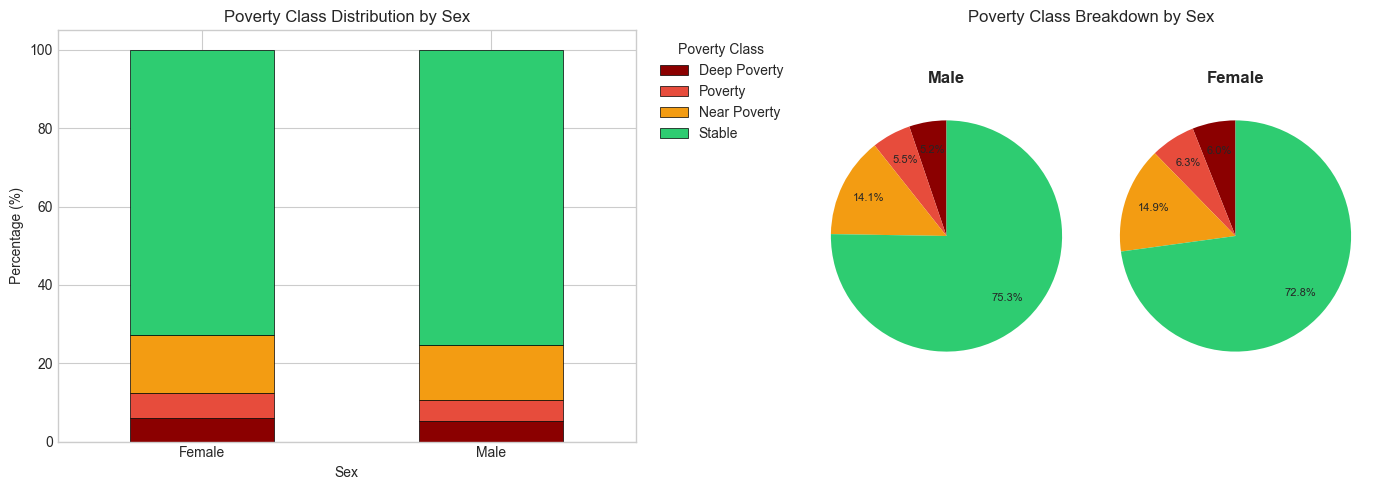


Poverty Class Distribution by Sex (%):
poverty_class  Deep Poverty  Poverty  Near Poverty  Stable
sex                                                       
Female                  6.0      6.3          14.9    72.8
Male                    5.2      5.5          14.1    75.3


In [20]:
# Poverty Class Distribution by Sex
sex_poverty = con.execute(f"""
SELECT
    CASE SEX WHEN 1 THEN 'Male' WHEN 2 THEN 'Female' END AS sex,
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count
FROM {TABLE}
WHERE SEX IS NOT NULL AND {TARGET} IS NOT NULL
GROUP BY 1, 2
""").fetchdf()

# Pivot for visualization
sex_pivot = sex_poverty.pivot(index='sex', columns='poverty_class', values='count').fillna(0)
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
sex_pivot = sex_pivot[class_order]
sex_pivot_pct = sex_pivot.div(sex_pivot.sum(axis=1), axis=0) * 100

class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
sex_pivot_pct.plot(kind='bar', stacked=True, ax=axes[0],
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Sex')
axes[0].legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Pie charts for each sex
for i, sex in enumerate(['Male', 'Female']):
    ax_pie = axes[1].inset_axes([i*0.5, 0, 0.5, 1])
    data = sex_pivot.loc[sex]
    colors = [class_colors[c] for c in class_order]
    wedges, texts, autotexts = ax_pie.pie(data, labels=None, autopct='%1.1f%%', 
                                           colors=colors, startangle=90, pctdistance=0.75)
    ax_pie.set_title(sex, fontsize=12, fontweight='bold')
    for autotext in autotexts:
        autotext.set_fontsize(8)
axes[1].axis('off')
axes[1].set_title('Poverty Class Breakdown by Sex', fontsize=12)

plt.tight_layout()
plt.savefig('EDA_data/duckdb_poverty_class_by_sex.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Sex (%):")
print(sex_pivot_pct.round(1).to_string())

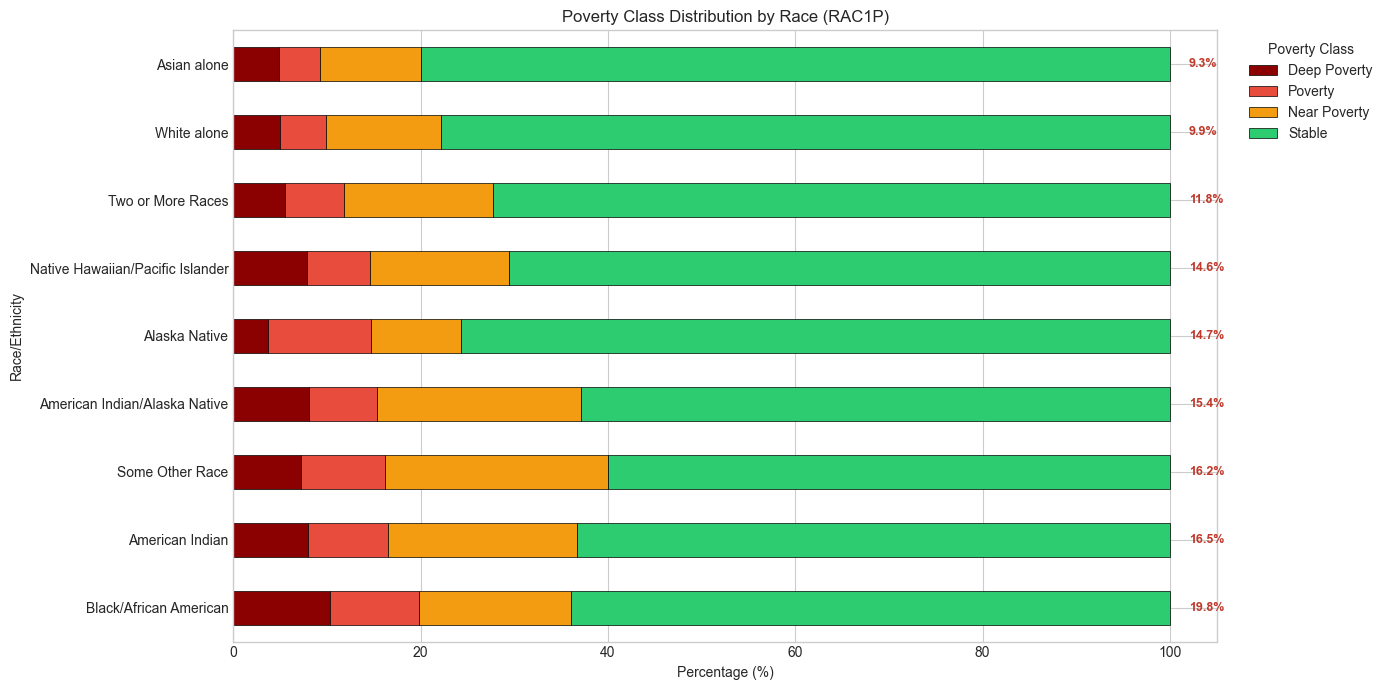


Poverty Rate by Race (Deep Poverty + Poverty %):
race
Black/African American              19.8
American Indian                     16.5
Some Other Race                     16.2
American Indian/Alaska Native       15.4
Alaska Native                       14.7
Native Hawaiian/Pacific Islander    14.6
Two or More Races                   11.8
White alone                          9.9
Asian alone                          9.3


In [21]:
# Poverty Class Distribution by Race/Ethnicity (RAC1P)
race_poverty = con.execute(f"""
SELECT
    CASE RAC1P
        WHEN 1 THEN 'White alone'
        WHEN 2 THEN 'Black/African American'
        WHEN 3 THEN 'American Indian'
        WHEN 4 THEN 'Alaska Native'
        WHEN 5 THEN 'American Indian/Alaska Native'
        WHEN 6 THEN 'Asian alone'
        WHEN 7 THEN 'Native Hawaiian/Pacific Islander'
        WHEN 8 THEN 'Some Other Race'
        WHEN 9 THEN 'Two or More Races'
    END AS race,
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count
FROM {TABLE}
WHERE RAC1P IS NOT NULL AND {TARGET} IS NOT NULL
GROUP BY 1, 2
""").fetchdf()

# Pivot for visualization
race_pivot = race_poverty.pivot(index='race', columns='poverty_class', values='count').fillna(0)
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
race_pivot = race_pivot[class_order]
race_pivot_pct = race_pivot.div(race_pivot.sum(axis=1), axis=0) * 100

# Sort by poverty rate
vulnerable_rate = race_pivot_pct['Deep Poverty'] + race_pivot_pct['Poverty']
race_pivot_pct = race_pivot_pct.loc[vulnerable_rate.sort_values(ascending=False).index]

class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

fig, ax = plt.subplots(figsize=(14, 7))
race_pivot_pct.plot(kind='barh', stacked=True, ax=ax,
                    color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
ax.set_xlabel('Percentage (%)')
ax.set_ylabel('Race/Ethnicity')
ax.set_title('Poverty Class Distribution by Race (RAC1P)')
ax.legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add vulnerable rate labels
for i, (idx, row) in enumerate(race_pivot_pct.iterrows()):
    vuln = row['Deep Poverty'] + row['Poverty']
    ax.text(102, i, f'{vuln:.1f}%', va='center', fontsize=9, fontweight='bold', color='#c0392b')

plt.tight_layout()
plt.savefig('EDA_data/duckdb_poverty_class_by_race.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Race (Deep Poverty + Poverty %):")
vulnerable_rate_sorted = vulnerable_rate.sort_values(ascending=False)
print(vulnerable_rate_sorted.round(1).to_string())

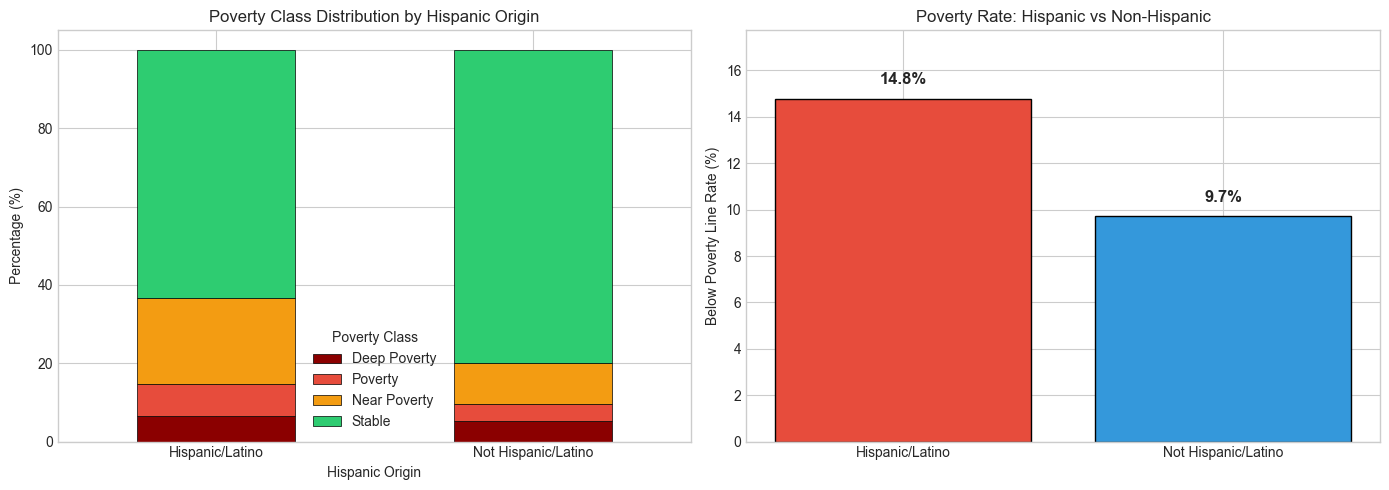


Poverty Rate Comparison:
  Hispanic/Latino: 14.8%
  Not Hispanic/Latino: 9.7%


In [22]:
# Poverty Class Distribution by Hispanic Origin
hisp_poverty = con.execute(f"""
SELECT
    CASE WHEN HISP > 1 THEN 'Hispanic/Latino' ELSE 'Not Hispanic/Latino' END AS hispanic,
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count
FROM {TABLE}
WHERE HISP IS NOT NULL AND {TARGET} IS NOT NULL
GROUP BY 1, 2
""").fetchdf()

hisp_pivot = hisp_poverty.pivot(index='hispanic', columns='poverty_class', values='count').fillna(0)
hisp_pivot = hisp_pivot[class_order]
hisp_pivot_pct = hisp_pivot.div(hisp_pivot.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
hisp_pivot_pct.plot(kind='bar', stacked=True, ax=axes[0],
                    color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Hispanic Origin')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Hispanic Origin')
axes[0].legend(title='Poverty Class')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Comparison bar chart
vulnerable_hisp = hisp_pivot_pct['Deep Poverty'] + hisp_pivot_pct['Poverty']
colors_bar = ['#e74c3c', '#3498db']
bars = axes[1].bar(vulnerable_hisp.index, vulnerable_hisp.values, color=colors_bar, edgecolor='black')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate: Hispanic vs Non-Hispanic')
axes[1].set_ylim(0, max(vulnerable_hisp.values) * 1.2)

for bar, rate in zip(bars, vulnerable_hisp.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_data/duckdb_poverty_class_by_hispanic.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPoverty Rate Comparison:")
for idx, rate in vulnerable_hisp.items():
    print(f"  {idx}: {rate:.1f}%")

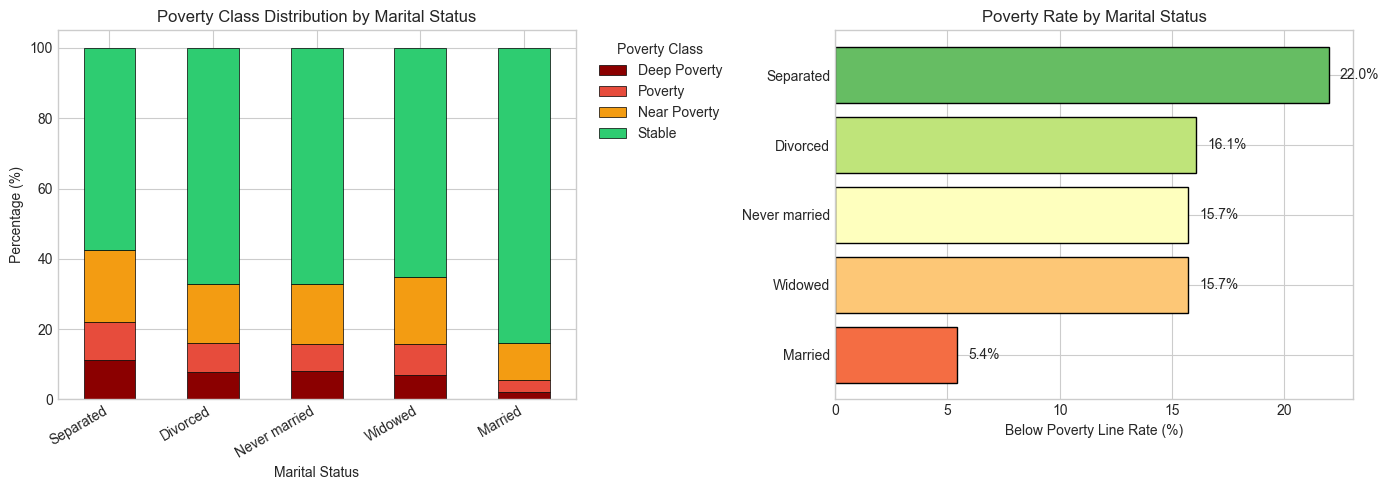


Poverty Rate by Marital Status:
marital_status
Separated        22.0
Divorced         16.1
Never married    15.7
Widowed          15.7
Married           5.4


In [23]:
# Poverty Class Distribution by Marital Status
mar_poverty = con.execute(f"""
SELECT
    CASE MAR
        WHEN 1 THEN 'Married'
        WHEN 2 THEN 'Widowed'
        WHEN 3 THEN 'Divorced'
        WHEN 4 THEN 'Separated'
        WHEN 5 THEN 'Never married'
    END AS marital_status,
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count
FROM {TABLE}
WHERE MAR IS NOT NULL AND {TARGET} IS NOT NULL
GROUP BY 1, 2
""").fetchdf()

mar_pivot = mar_poverty.pivot(index='marital_status', columns='poverty_class', values='count').fillna(0)
mar_pivot = mar_pivot[class_order]
mar_pivot_pct = mar_pivot.div(mar_pivot.sum(axis=1), axis=0) * 100

# Sort by poverty rate
vulnerable_rate = mar_pivot_pct['Deep Poverty'] + mar_pivot_pct['Poverty']
mar_pivot_pct = mar_pivot_pct.loc[vulnerable_rate.sort_values(ascending=False).index]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
mar_pivot_pct.plot(kind='bar', stacked=True, ax=axes[0],
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Marital Status')
axes[0].legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha='right')

# Bar chart of vulnerable rates
vulnerable_sorted = vulnerable_rate.sort_values(ascending=True)
colors_gradient = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(vulnerable_sorted)))
bars = axes[1].barh(range(len(vulnerable_sorted)), vulnerable_sorted.values, color=colors_gradient, edgecolor='black')
axes[1].set_yticks(range(len(vulnerable_sorted)))
axes[1].set_yticklabels(vulnerable_sorted.index)
axes[1].set_xlabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Marital Status')
for bar, rate in zip(bars, vulnerable_sorted.values):
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{rate:.1f}%', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('EDA_data/duckdb_poverty_class_by_marital.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Marital Status:")
print(vulnerable_rate.sort_values(ascending=False).round(1).to_string())

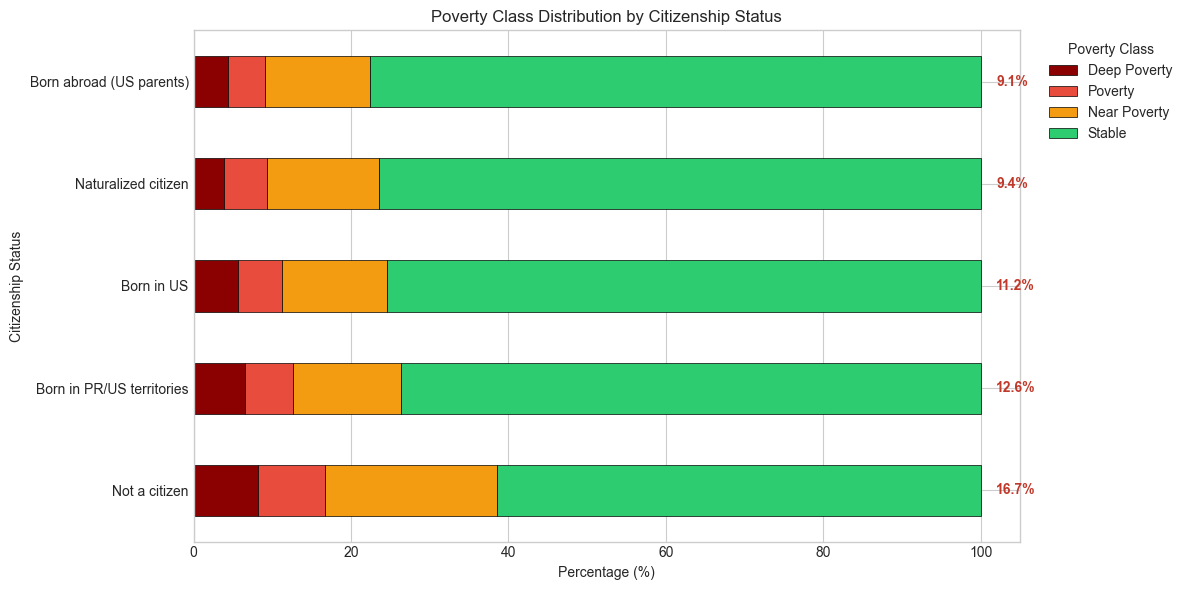


Poverty Rate by Citizenship Status:
citizenship
Not a citizen                16.7
Born in PR/US territories    12.6
Born in US                   11.2
Naturalized citizen           9.4
Born abroad (US parents)      9.1


In [24]:
# Poverty Class Distribution by Citizenship Status
cit_poverty = con.execute(f"""
SELECT
    CASE CIT
        WHEN 1 THEN 'Born in US'
        WHEN 2 THEN 'Born in PR/US territories'
        WHEN 3 THEN 'Born abroad (US parents)'
        WHEN 4 THEN 'Naturalized citizen'
        WHEN 5 THEN 'Not a citizen'
    END AS citizenship,
    CASE 
        WHEN {TARGET} <= 50 THEN 'Deep Poverty'
        WHEN {TARGET} <= 100 THEN 'Poverty'
        WHEN {TARGET} <= 200 THEN 'Near Poverty'
        ELSE 'Stable'
    END AS poverty_class,
    COUNT(*) AS count
FROM {TABLE}
WHERE CIT IS NOT NULL AND {TARGET} IS NOT NULL
GROUP BY 1, 2
""").fetchdf()

cit_pivot = cit_poverty.pivot(index='citizenship', columns='poverty_class', values='count').fillna(0)
cit_pivot = cit_pivot[class_order]
cit_pivot_pct = cit_pivot.div(cit_pivot.sum(axis=1), axis=0) * 100

# Sort by poverty rate
vulnerable_rate = cit_pivot_pct['Deep Poverty'] + cit_pivot_pct['Poverty']
cit_pivot_pct = cit_pivot_pct.loc[vulnerable_rate.sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(12, 6))
cit_pivot_pct.plot(kind='barh', stacked=True, ax=ax,
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
ax.set_xlabel('Percentage (%)')
ax.set_ylabel('Citizenship Status')
ax.set_title('Poverty Class Distribution by Citizenship Status')
ax.legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add vulnerable rate labels
for i, (idx, row) in enumerate(cit_pivot_pct.iterrows()):
    vuln = row['Deep Poverty'] + row['Poverty']
    ax.text(102, i, f'{vuln:.1f}%', va='center', fontsize=10, fontweight='bold', color='#c0392b')

plt.tight_layout()
plt.savefig('EDA_data/duckdb_poverty_class_by_citizenship.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Citizenship Status:")
print(vulnerable_rate.sort_values(ascending=False).round(1).to_string())